# Using PaLM to Cluster Products Based on Descriptions

## Reference
* [GCP Gen AI Training Path Lab - Use the PaLM API to Cluster Products Based on Descriptions](https://partner.cloudskillsboost.google/paths/165/course_templates/948/labs/485069)


## Introduction
In this lab, you're going to use a list of product descriptions to create a model that will cluster products together. To train the clustering model, you need to find the meaning of the text in the descriptions. You'll take advantage of the language understanding of the PaLM model to generate the embedded meanings!

## Setup
To access the PaLM Embeddings, you need to set up the client to access Vertex AI. Start by installing one of the latest versions of the Python client library.

All of the imports will be done up front to keep the notebook tidy.


### Installs
Make sure we have a new enough version of the Vertex AI Python client library to use the `textembeddings-gecko` model.

In [1]:
!pip3 install "google-cloud-aiplatform>=1.27"

After the install, we need to restart the kernel to use the new library version.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Imports
Import all of the modules needed for the notebook.

Most modules in the Python client library belong to the package `google.cloud`, but Vertex AI is an exception.



In [3]:
import vertexai
from vertexai.language_models import TextEmbeddingModel

from sklearn.cluster import KMeans

import google.auth
from google.cloud import storage
from google.cloud import aiplatform
from google.colab import userdata

import math
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from typing import Generator, List, Optional, Tuple
import functools
import time
from concurrent.futures import ThreadPoolExecutor

import pickle
from urllib.request import urlopen

from collections import Counter

### User Authentication
If you are using Colab, uncomment this cell and run it to authenticate as your user for Google Cloud.

Shortcut: Select the cell contents and press `Ctrl/Cmd + /`.

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

Run the cell below to retrieve the credentials for intializing access to Vertex AI.

In [ ]:
credentials, _ = google.auth.default()
credentials

### Client setup

Configure your project ID in `MY_PROJECT`.

If you want to use a specific Vertex AI location, set it as `VERTEX_LOCATION`. We'll default to us-central1.

In [ ]:
MY_PROJECT='qwiklabs-gcp-03-3bbbdb3ced9d'
VERTEX_LOCATION='us-central1'

In [ ]:
vertexai.init(
    project=userdata.get('GCP_PROJECT'),
    location=VERTEX_LOCATION,
    #credentials set above
    credentials=credentials
)

## Data
The product description data we are using was gathered for the paper

**Justifying recommendations using distantly-labeled reviews and fined-grained aspects**\
Jianmo Ni, Jiacheng Li, Julian McAuley\
_Empirical Methods in Natural Language Processing (EMNLP)_, 2019\
[pdf](http://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf)

This [dataset](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/index.html) includes many additional fields that you're not going to use, including reviews from users. To keep this lab more focused, the data has already been parsed and cleaned. We've taken a sample of 2,000 products each across 5 categories, for a total of 10,000 products. The clustering model you'll train will be used to attempt to rediscover those categories!

The cleaned data only includes the name of the item and the description. This is formatted into a CSV file, which is hosted on Cloud Storage.

The five original categories are as follows:
* all beauty
* appliances
* musical instruments
* pantry
* software

In [4]:
URL = 'https://storage.googleapis.com/cloud-training/specialized-training/model_garden/products.csv.gz'
products_df = pd.read_csv(URL)

You can preview the data in the following cell. Verify that there are indeed 10,000 rows of data consisting of two columns: name and description.

In [5]:
products_df

,name,description
0,"NAILTEK CITRA Formula 3 Protection for Dry, Br...","NAILTEK CITRA Formula #3 Protection for Dry, B..."
1,Wildberry Incense Sticks: Vanilla,"Vanilla incense is smooth, creamy and delectable."
2,Wonder Pro Professional Red Rubber Sponge #010...,Wonder Pro Professional Red Sponges-2 pack
3,Ronson 2.75 oz(78 Gram) Butane Multi-Fill/12 Pk.,Fills up to 20 disposable lighters per bottle.
4,"NUKSIT 10% Sulfur Ointment - Large tub 4oz, Po...",This 4 oz size is an excellent value. Swiss fo...
...,...,...
9995,Mayo Clinic Family Health 3.0 (PC CD Jewel Case),Mayo Clinic one of the most trusted names in m...
9996,SecurErase 8: Permanently Erase Your Hard Drive,SecurErase overwrites the data that sits unuse...
9997,Finale 2008-2009 Tutorial DVD,156 videos with a running time of over 8.5 hou...
9998,Putt-Putt Joins the Circus - PC/Mac,Step Right Up! Discover the Circus with Putt-...


In [ ]:
len(products_df)

10000

## Embeddings Model


With the product information loaded, you can now get the embeddings for the description. Start by loading the model. Check the model card in Model Garden for how to get started, or view the API documentation.

[PaLM Text Embeddings Model Card](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/textembedding-gecko)

[TexEmbeddingModel API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextEmbeddingModel)

[TextEmbeddingModel code](https://github.com/googleapis/python-aiplatform/blob/main/vertexai/language_models/_language_models.py#L510)

In [ ]:
model = TextEmbeddingModel.from_pretrained("textembedding-gecko")

Confirm that we are using the model from Model Garden that we expect, which is the TextEmbeddingModel.

In [ ]:
type(model)

vertexai.language_models.TextEmbeddingModel

Let's try calling the model with a couple example sentences, just to see the basic process. We'll print the first 15 dimensions of each vector to see what the result looks like.

In [ ]:
embeddings = model.get_embeddings(["Dinner in New York City", "Dinner in Paris"])
for embedding in embeddings:
    vector = embedding.values
    print(vector[:15])
    print('\n-----\n')

[0.03092864528298378, -0.029868636280298233, -0.029459740966558456, -0.0009445197647437453, 0.002139341551810503, 0.003000705735757947, 0.013629520311951637, 0.04873180389404297, 0.010373848490417004, 0.026051972061395645, 0.016042839735746384, -0.0191232617944479, -0.01023846585303545, -0.04757988452911377, -0.006645353976637125]

-----

[0.039646610617637634, -0.006595339626073837, -0.017672155052423477, -0.036731693893671036, 0.026284098625183105, -0.05156594514846802, -0.006187012884765863, 0.042615681886672974, 0.024405168369412422, 0.04950619116425514, -0.0035881802905350924, 0.005918171722441912, -0.008285507559776306, -0.03436281532049179, 0.027929840609431267]

-----



In [ ]:
assert len(embeddings) == len(["Dinner in New York City", "Dinner in Paris"])
assert len(embeddings[0].values) == 768 # assert that the embeddings generated are dimension (768,)
assert len(embeddings[1].values) == 768 # assert that the embeddings generated are dimension (768,)

In [ ]:
print(f'Response type: {type(embeddings)}')
print(f'Each response type: {type(embeddings[0])}')

Response type: <class 'list'>
Each response type: <class 'vertexai.language_models.TextEmbedding'>


The Python client puts the responses from the model into a list in order of the requested sentences.

In [ ]:
len(embeddings)

2

The TextEmbeddings are a set of floating point values representing the 768 dimensions used by PaLM for understanding the meaning of text. Later, we'll convert these lists of floats to numpy ndarrays for easier use.

In [ ]:
print(f'Values: {len(embeddings[0].values)}')
print(f'Value type: {type(embeddings[0].values[0])}')

Values: 768
Value type: <class 'float'>


According to the [documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings#get_text_embeddings_for_a_snippet_of_text), the API has a limit of 5 input texts (product descriptions in our case) per API call. With a batch size of 5 and 10,000 product descriptions to embed, we'll need to make 2,000 calls to the API. It's time to turn the basic example into a function for more utility.

#### Function to call the model
This function does what our basic example does, which is call the `get_embeddings` method to convert our text. It adds very basic error handling, which should be expanded for production use.

In [ ]:
# Define an embedding method that uses the model
def encode_texts_to_embeddings(sentences: List[str]) -> List[Optional[List[float]]]:
    try:
        embeddings = model.get_embeddings(sentences)
        return [embedding.values for embedding in embeddings]
    except Exception:
        return [None for _ in range(len(sentences))]

#### Define two more helper functions for converting text to embeddings

- generate_batches:  This method splits `sentences` into batches of 5 before sending to the embedding API.
- encode_text_to_embedding_batched: This method calls `generate_batches` to handle batching and then calls the embedding API via `encode_texts_to_embeddings`. It also handles rate-limiting using `time.sleep`. For production use cases, you would want a more sophisticated rate-limiting mechanism that takes retries into account.

In [ ]:
# Generator function to yield batches of descriptions
def generate_batches(
    descriptions: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    for i in range(0, len(descriptions), batch_size):
        yield descriptions[i : i + batch_size]


def encode_text_to_embedding_batched(
    descriptions: List[str], api_calls_per_minute: int = 20, batch_size: int = 5
) -> Tuple[List[bool], np.ndarray]:

    embeddings_list: List[List[float]] = []

    # Prepare the batches using a generator
    batches = generate_batches(descriptions, batch_size)

    seconds_per_job = 60 / api_calls_per_minute

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in tqdm(
            batches, total=math.ceil(len(descriptions) / batch_size), position=0
        ):
            futures.append(
                executor.submit(functools.partial(encode_texts_to_embeddings), batch)
            )
            time.sleep(seconds_per_job)

        for future in futures:
            embeddings_list.extend(future.result())

    is_successful = [
        embedding is not None for sentence, embedding in zip(descriptions, embeddings_list)
    ]
    embeddings_list_successful = np.squeeze(
        np.stack([embedding for embedding in embeddings_list if embedding is not None])
    )
    return is_successful, embeddings_list_successful

#### Generate Embeddings

To generate the embeddings, we will call the batch helper function. However, the Qwiklabs environment has a low rate quota, so this process will take a long time to complete. Luckily, an important principle of the embeddings is that they won't substantially change no matter when you do the conversion! We can compute the embeddings once, store them, then load them whenever we need them again.

The below cell is the code for generating the embeddings. It is commented out since you won't be using it, but it does show you the process for your own use later! Make sure to change the `api_calls_per_minute` parameter based on [your own quota rate limit!](https://console.cloud.google.com/iam-admin/quotas?referrer=search&pageState=(%22allQuotasTable%22:(%22f%22:%22%255B%257B_22k_22_3A_22_22_2C_22t_22_3A10_2C_22v_22_3A_22_5C_22base_model_3Atextembedding-gecko_5C_22_22_2C_22s_22_3Atrue%257D%255D%22)))

In [ ]:
# descriptions = products_df['description'].values.tolist()
# response = encode_text_to_embedding_batched(descriptions, api_calls_per_minute=20)

The full response is hosted on Cloud Storage so we can import it and pick up right where the previous cell would have left us.

In [6]:
URL = 'https://storage.googleapis.com/cloud-training/specialized-training/model_garden/embeddings-response.pkl'
response = pickle.load(urlopen(URL))

The `response` created by the `encode_text_to_embeddings_batched` function is a Tuple of (List[bool], ndarray)

The first tuple item represents whether the API call was successful or not. There should be an equal number of responses to the size of the original product description list (10,000). These should all be True to indicate we have embeddings for every description.

In [ ]:
print('Item 0')
print(f'\ttype: {type(response[0])}')
print(f'\tvalues: {len(response[0])}')
# Test to make sure all responses are True.
print(f'All embeddings requests completed successfully: {all(response[0])}')

Item 0
	type: <class 'list'>
	values: 10000
All embeddings requests completed successfully: True


The second tuple item is a numpy ndarray of the 768-dimension embedding vectors provided by the model for each product description.

In [ ]:
print('Item 1')
print(f'\ttype: {type(response[1])}')
print(f'\tshape: {response[1].shape}')
print(f'\tvector data type: {response[1].dtype}')

Item 1
	type: <class 'numpy.ndarray'>
	shape: (10000, 768)
	vector data type: float64


Even though the giant string of floating point numbers doesn't mean anything to us as humans, it's still interesting to see.

In [ ]:
print(f'Original text: \n{products_df["description"][0]}\nEmbedding vector:')
print(response[1][0])

Original text: 
NAILTEK CITRA Formula #3 Protection for Dry, Brittle Nails .47oz  Conditions brittle dry nails, replenishes the natural moisture of the nails and provides the hydration necessary to resist stress and enhance survivability.
Embedding vector:
[ 7.15385750e-03 -4.29799780e-02  1.26909539e-02  4.06474955e-02
  3.32920589e-02 -3.13577242e-02  1.17542723e-03  4.91597764e-02
 -3.15157063e-02  2.28883326e-02 -1.06803495e-02 -2.03404780e-02
 -8.10595509e-03  5.78571521e-02 -2.30540130e-02  2.81607080e-03
 -3.40594761e-02  1.62891373e-02  5.20878360e-02 -2.91049127e-02
 -3.44198048e-02  1.58195440e-02  4.27926099e-03 -2.42937859e-02
 -4.03086506e-02 -1.00072347e-01  3.45601961e-02  3.35591137e-02
 -9.63283181e-02  1.69923436e-02  2.54319627e-02 -1.66077930e-02
  7.08263554e-03 -4.55290545e-03  5.14889322e-02 -2.29180660e-02
 -3.43148340e-03  3.82181592e-02  1.08421817e-02  3.67002264e-02
  5.52216880e-02  7.56995240e-03 -8.73890519e-03 -1.41722541e-02
 -4.04832661e-02 -3.24015990

## Clustering Model
With the embeddings computed, you can use those to create categories representing similar products. Notice that the dataset you loaded is not labeled for which category each product belongs to. However, those product categories do exist the source data.

You'll use a K-Means model to find similarities in the embedding vectors. Using scikit-learn, the [KMeans model](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) directly accepts an ndarray, which our embedding vectors are formatted as thanks to the helper functions!

As mentioned, the sample data came from 5 product categories, so we're going to have the model learn 5 clusters. With the small dataset we're using, training the clustering model will take almost no time.

In [7]:
embeddings = response[1]
kmeans = KMeans(n_clusters=5, n_init="auto").fit(embeddings)

In [8]:
print(embeddings.shape)
print(type(embeddings))

(10000, 768)
<class 'numpy.ndarray'>


Fitting the model also provides us with the predictions for the values used to train the model in the `labels_` property.

In [ ]:
len(kmeans.labels_)

10000

We can sanity check that by calling the `predict` function directly, which is also how you'd cluster future products now that we've trained the model!

In [ ]:
predictions = kmeans.predict(embeddings)

In [ ]:
kmeans.labels_[:20]

array([1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
predictions[:20]

array([1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
# Distinct labels predicted by KMeans
set(kmeans.labels_) # 5 distinct labels - 0-4

{0, 1, 2, 3, 4}

#### Evaluate the clusters
Let's attach the predicted clusters to the original data and see some example products from each cluster to see how well the model performed.

As a reminder, the data has 2,000 products from each of 5 categories.

In [ ]:
products_df['category'] = predictions

In [ ]:
products_df.groupby('category').count()['name']

category
0    1601
1    2057
2    2074
3    2542
4    1726
Name: name, dtype: int64

We can see that the model did not entirely accurately recreate the categories as there are not exactly 2,000 in each cluster. However, the performance isn't terrible for having spent about one second training.

What you should also know about the input data is that it was sorted by category. Each block of 2,000 rows is one product category. Let's see how well the model predicts each of the different categories.

In [9]:
# Create named slices for easier reference
beauty = slice(2000)
appliance = slice(2000,4000)
instrument = slice(4000,6000)
pantry = slice(6000,8000)
software = slice(8000,10000)

beauty_cnts = Counter(predictions[beauty])
appliance_cnts = Counter(predictions[appliance])
instrument_cnts = Counter(predictions[instrument])
pantry_cnts = Counter(predictions[pantry])
software_cnts = Counter(predictions[software])

product_pred_cnts = [beauty_cnts, appliance_cnts, instrument_cnts, pantry_cnts, software_cnts]
for product_cnt in product_pred_cnts:
    print(product_cnt)

NameError: name 'predictions' is not defined

With the set of predictions and the counts per category, we can now label the clusters based on the highest number of predictions. With many clustering tasks, we won't have a source of ground truth like in this example, so figuring out names for your clusters will be up to you. You'll do additional analysis of the features of the objects that are predicted to be in the same cluster by your model.

In [10]:
def most_likely_cluster(counted_dict):
    return max(counted_dict, key=counted_dict.get)

product_category_list = ['all_beauty', 'appliance', 'instrument', 'pantry', 'software']

product_clusters = []
for product in product_pred_cnts:
    product_clusters.append(most_likely_cluster(product))

keys = [0, 1, 2, 3, 4] # simple list of index values as the products are inserted
row_names = dict(zip(keys, product_category_list))
cluster_map = dict(zip(product_clusters, product_category_list))
print(row_names) # ascending alpha order
print(cluster_map) # predictions

NameError: name 'product_pred_cnts' is not defined

Add all of that information to a new DataFrame for easier visualization. The prediction counts get added in as raw information, then we'll update row and column names to match the product categories.

In [ ]:
products_df.head()

,name,description,category
0,"NAILTEK CITRA Formula 3 Protection for Dry, Br...","NAILTEK CITRA Formula #3 Protection for Dry, B...",1
1,Wildberry Incense Sticks: Vanilla,"Vanilla incense is smooth, creamy and delectable.",0
2,Wonder Pro Professional Red Rubber Sponge #010...,Wonder Pro Professional Red Sponges-2 pack,1
3,Ronson 2.75 oz(78 Gram) Butane Multi-Fill/12 Pk.,Fills up to 20 disposable lighters per bottle.,1
4,"NUKSIT 10% Sulfur Ointment - Large tub 4oz, Po...",This 4 oz size is an excellent value. Swiss fo...,1


In [ ]:
correctness_df = pd.DataFrame.from_dict(product_pred_cnts)
correctness_df.rename(index=row_names, inplace=True)
correctness_df.rename(columns=cluster_map, inplace=True)
correctness_df.sort_index(axis=0, inplace=True)
correctness_df.sort_index(axis=1, inplace=True)

In [ ]:
correctness_df.head()

,all_beauty,appliance,instrument,pantry,software
all_beauty,1511,10.0,332,101,46
appliance,37,1709.0,196,27,31
instrument,31,4.0,1904,7,54
pantry,461,NaN,46,1463,30
software,17,3.0,64,3,1913


From this confusion matrix, we can see which categories have the most recognizable patterns of descriptions. Down the diagonal is the count of correct predictions.

With this data, the model predicted software and instruments very well. Very few of those predictions were wrong. However, it also frequently confused appliances and beauty products for instruments. You can see which descriptions were confusing by selecting those products from the original dataframe.

In [ ]:
instrument_category = product_clusters[2]

In [ ]:
products_df.iloc[beauty].query(f'category == {instrument_category}')

,name,description,category
7,Ambu 276-000-001 Res-Cue Pump,Ambu Hand held Rescue Pump,3
12,Vera Bradley Little Flap Hipster (Cocoa Moss) ...,Vera Bradley Little Flap Hipster Cocoa Moss,3
27,"JE136 Antique Ring, Faux Emerald Ring, Vintage...","JE136 Antique Ring, Faux Emerald Ring, Vintage...",3
31,Hot Sweet Lovely Anime Lolita Cosplay Fancy Ne...,Height:approx.10cm from the fur tip to the ear...,3
34,ImZauberwald Peyote Mandala UV Patch 7.8 Inch ...,Handmade UV active embroidery patch. You can s...,3
...,...,...,...
1978,Best Selling in Asia- Super Moisture Cc Cushio...,Item details: # 21 Light Beige,3
1980,Boyds TF Wuzzies Timothy F Wuzzle Soldier Tedd...,From Boyds Plush T.F. Wuzzies Collection Timot...,3
1982,Stunning Silver Colored Clover Shaped Clip On ...,Exquisite Clover Shaped Bracelet Charm In Silv...,3
1998,Bestpriceam (Tm) Infinity Love Heart Pearl Fri...,Infinity Love Heart Friendship Antique Leather...,3


We can compare those descriptions with the descriptions from instruments that were correctly predicted.

In [ ]:
products_df.iloc[instrument].query(f'category == {instrument_category}')

,name,description,category
4000,Oscar Schmidt OR6CEB-O-U Acoustic Electric Res...,The OR6CE is a biscuit resonator guitar with c...,3
4001,"Vacuum Tube Set for Fender Bandmaster VM Head,...",(2)T-12AX7-S-JJ (1)T-6L6GC-JJ-MP (Apex Matched...,3
4002,Liverpool Double Star Drum Stick/Mallet Comb S...,Liverpool Drum Sticks Mallet / Drum Stick Combo,3
4003,Didgeridoo Store Decorative Didgeridoo Midnigh...,Didgeridoo Store Decorative Didgeridoo Midnigh...,3
4004,WellieSTR (A Pair) Real Leather Accordion/Acco...,(A Pair) Real Leather Accordion/Accordian Bell...,3
...,...,...,...
5995,MBT Lighting PAR56 Par Can - Black,Par56 Par Can. Made by MBT Lighting.,3
5996,Blast King I49BMIC20B Female XLR to 1/4-Inch P...,"Blast King MICROPHONE CABLE, FEMALE XLR TO 1/4"" P",3
5997,Kona Guitars KA15T 10-Watt Amplifier with Buil...,Kona 10 Watt Amplifier with Built-in Tuner and...,3
5998,BEHRINGER STUDIO CONDENSER MICROPHONE T-47,Vacuum Tube Condenser Microphone,3


They don't look that similar to me, but they apparently look similar to the model at the embedding vector level!

## Estimate the Silhouette score as an optimization exercise

Reference: [Using silhouette score in sckikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In general:
* Tune the `num_cluster` hyperparameter

In [17]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [30]:
def plot_silhouette(
      range_n_clusters: int,
      train_data: np.ndarray
    ):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(train_data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init='auto').fit(train_data)
        cluster_labels = clusterer.labels_

        silhouette_avg = silhouette_score(train_data, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(train_data, cluster_labels)

        # print(type(sample_silhouette_values))
        # print(sample_silhouette_values.shape)
        # print(sample_silhouette_values[0:20])

        y_lower = 10
        for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(
              np.arange(y_lower, y_upper),
              0,
              ith_cluster_silhouette_values,
              facecolor=color,
              edgecolor=color,
              alpha=0.7,
          )

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            train_data[:, 0], train_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

        plt.show()

In [13]:
train_labels = \
 [0 for _ in range(2000)] + \
 [1 for _ in range(2000)] + \
 [2 for _ in range(2000)] + \
 [3 for _ in range(2000)] + \
 [4 for _ in range(2000)]

assert len([x for x in train_labels if x == 0]) == 2000
assert len([x for x in train_labels if x == 1]) == 2000
assert len([x for x in train_labels if x == 2]) == 2000
assert len([x for x in train_labels if x == 3]) == 2000
assert len([x for x in train_labels if x == 4]) == 2000
assert len([x for x in train_labels if x == 5]) == 0

assert embeddings.shape == (10000, 768)
assert len(train_labels) == embeddings.shape[0]

### Try with lower range of `num_clusters`

In [31]:
plot_silhouette(
    range_n_clusters=[2, 3, 4, 5, 6],
    train_data=embeddings
)

Output hidden; open in https://colab.research.google.com to view.

### Try with higher range of `num_clusters`

For n_clusters = 6 The average silhouette_score is : 0.05349657052094284


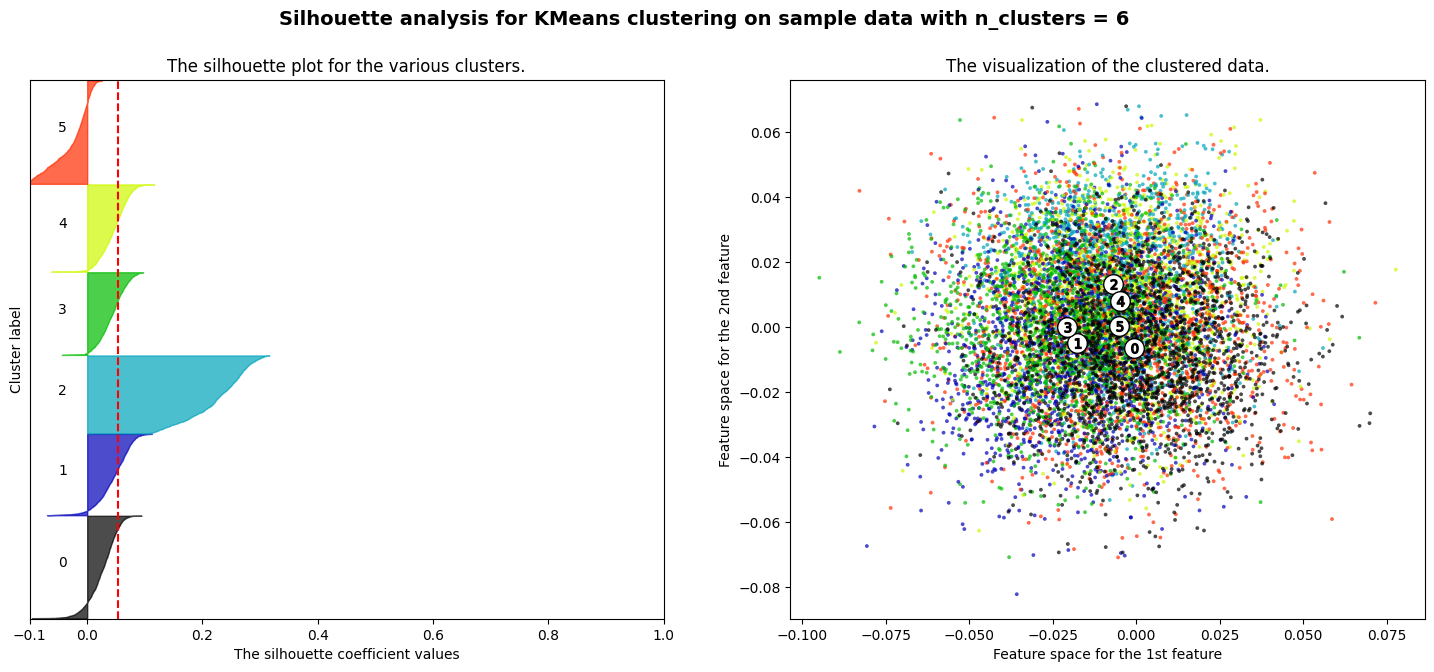

For n_clusters = 7 The average silhouette_score is : 0.04391509975363032


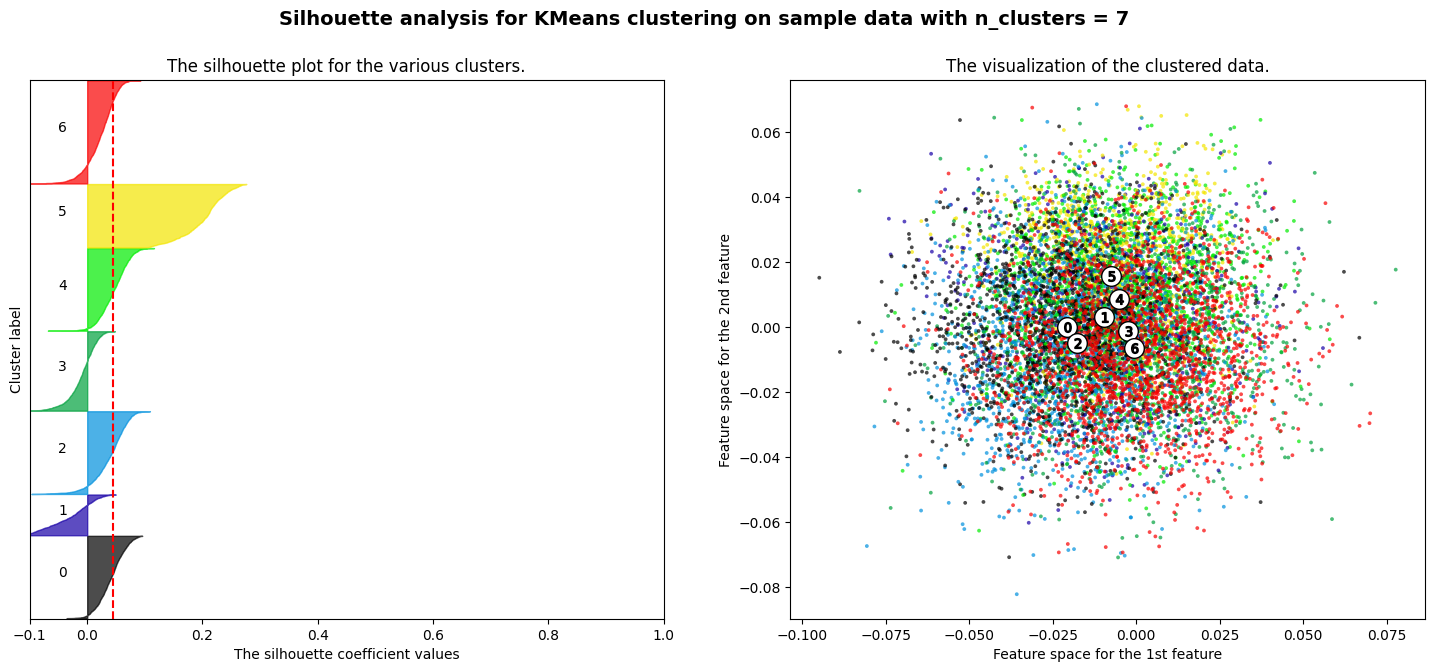

For n_clusters = 8 The average silhouette_score is : 0.025730677402322873


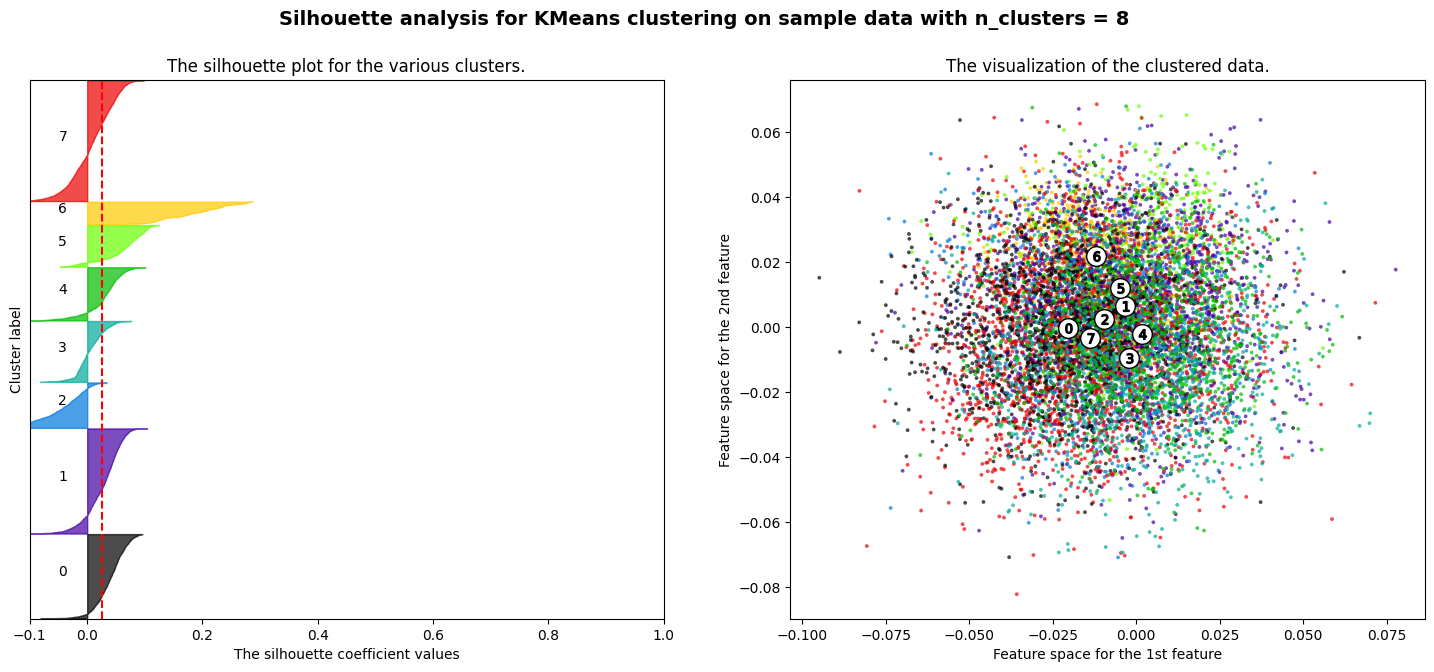

For n_clusters = 9 The average silhouette_score is : 0.043657611798030925


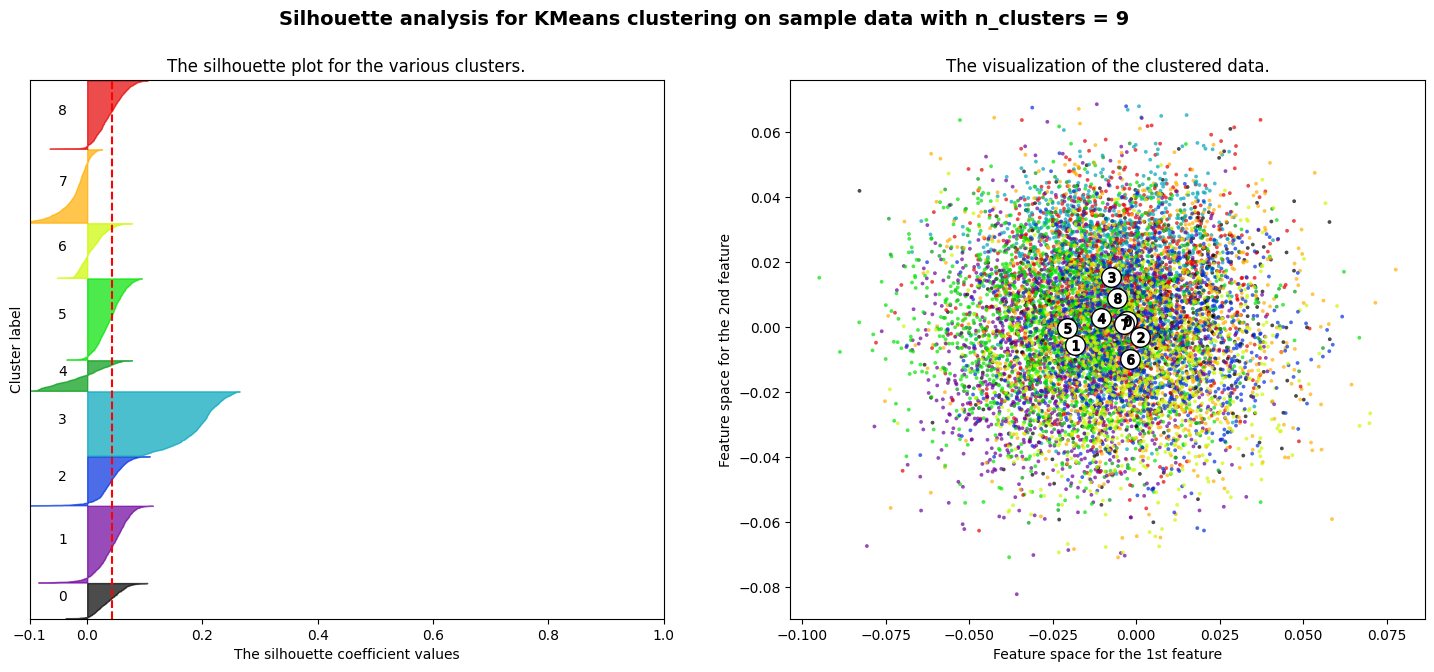

In [33]:
plot_silhouette(
    range_n_clusters=[6,7,8,9],
    train_data=embeddings
)

### Outcome

This didn't seem to improve things much at all - the best result was when `num_cluster` is 5.

I'll need to post to stackexchange to see how to improve this, and if there are other ways to tune `KMeans` models

## Save the model to Model Registry

### Save the model
Having the model available in the notebook is all well and good, but right now, it only lives in memory and is only accessible from within the notebook. That's not very useful. We can do better. First, let's save the model locally on the machine to prevent us from losing it during a reboot. We can use Pickle to export the model to disk.

In [ ]:
model_local_file = 'model.pkl'
with open(model_local_file, 'wb') as model_file:
    pickle.dump(kmeans, model_file)

At least now the model is persisted to local storage, but it's still not very available. A much better place to store it is Cloud Storage!

We'll default to using a Cloud Storage bucket name based on our project ID. You can set this to any Cloud Storage bucket you have access to.

In [ ]:
GCS_BUCKET=f"{MY_PROJECT}-productcluster"

In [ ]:
gcs_client = storage.Client()

The following cell will create the bucket. If you set the variable to an existing bucket, skip the following cell or it will throw an error.

In [ ]:
gcs_client.create_bucket(GCS_BUCKET)

Now we can upload the model to Cloud Storage.

In [ ]:
bucket = gcs_client.get_bucket(GCS_BUCKET)
gcs_model_path = f'PaLM_embeddings_product_cluster'
blob = bucket.blob(f'{gcs_model_path}/{model_local_file}')
blob.upload_from_filename(model_local_file)

To reload your model for future use in a notebook, simply retrive the pickled model file from Cloud Storage, then use pickle to load it again!

In [ ]:
with open(model_local_file, 'rb') as f:
    reloaded_kmeans = pickle.load(f)

reloaded_kmeans.predict(embeddings[:10])

Since we still have the original in memory, we can easily show the predictions from the reloaded model are the same as the original.

In [ ]:
kmeans.predict(embeddings[:10])

### Model Registry
Being in Cloud Storage means you're going to have 11-9s of durability so you know the model won't be lost, and now you can download it in other notebooks to use.

However, we can still do better!

You can't use the model directly from Cloud Storage to make predictions. You'd have to spin up a notebook or other server, retrieve the model, then load the model back into memory to use it again. That's a lot of work, and it doesn't let you use this model for any kind of real-time predictions.

Instead, wouldn't it be great if we could directly send embeddings to our model and not have to worry about the computing behind it? By adding the model to Model Registry, we can unlock the full power of Vertex AI to run our model at scale!

According to the [documentation](https://cloud.google.com/vertex-ai/docs/training/exporting-model-artifacts#scikit-learn), Vertex AI expects the model to be named `model.pkl` when importing to Model Registry, which is why we named it that above. To register the model, you pass in the directory (really, key prefix) for where Model Registry can find the pickled model in Cloud Storage. You also specify a serving container image, which your model will be injected into to run on Vertex AI.

In [ ]:
model_display_name = 'cluster_products_using_palm'
artifact_directory_uri = f'gs://{GCS_BUCKET}/{gcs_model_path}'
serving_container_image = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-2:latest'

vai_model = aiplatform.Model.upload(
            display_name=model_display_name,
            artifact_uri=artifact_directory_uri,
            serving_container_image_uri=serving_container_image)

vai_model.wait()

Now you can easily send batch predictions to your model, or publish it to an Endpoint for real-time applications!

### Use the model
Finally, with your model no longer in danger of being lost, and being substantially more usable in Model Registry, let's turn back to our local copy of the model to predict a few more products.

Here are a few more cleaned-up product descriptions from the original dataset that were not included in the sample, one from each category.

In [ ]:
new_products = ['Kinetronics StaticWisk Brush-7/8',
                'Range Kleen GE/Hotpoint Large Porcelain Drip Bowl 8"',
                'Game of Thrones (Theme from the HBO series) - EASY PIANO Sheet Music Single',
                'CADBURY Chocolate Candy Bar, English Toffee, 5.4 Ounce',
                'Star Trek: The Game Show']
new_descriptions = ['Fine quality anti-static lens brush. Made from a special blend of soft, natural hair and a conductive fiber. To use the brush, simply sweep the lens. The brush has a resistivity of 10-1 and will dissipate any static charge and release the dust.',
                    'Are your burner reflector bowls beyond rescue? Reasonably priced and easy to clean, replacement bowls will have your stove looking spiffy in a jiffy!',
                    'EASY Piano version of the popular theme song from the HBO series.',
                    'Enjoy the rich taste of premium milk chocolate with the satisfying crunch of English toffee. Make any moment more delicious with an Cadbury milk chocolate with English toffee pouch.',
                    'Star Trek: The Game Show'
]

First, generate the text embeddings

In [ ]:
new_embeddings = model.get_embeddings(new_descriptions)

The returned embeddings are in a TextEmbedding class. Convert that to an ndarray of floats to pass to the clustering model.

In [ ]:
new_embeddings_nd = np.squeeze(np.stack([embedding.values for embedding in new_embeddings if embedding is not None]))
new_predictions = kmeans.predict(new_embeddings_nd)

In [ ]:
new_predictions_clusters = [cluster_map[x] for x in new_predictions]
new_predictions_clusters

How did your model do?

When I ran this, the model got 4 of 5 correct. Not bad! It confused the musical instrument category for software, which was the most likely category for it to be wrong about based on my confusion matrix.

## Congratulations!

In this lab, you've converted a set of product descriptions into a vector representation using the PaLM Embeddings model. With that contextual information, you trained a clustering model to predict the category of the product based on the description. You then persisted the model to Cloud Storage, and most powerfully, added it to Model Registry. It's now ready to use in your Vertex AI pipelines!
